# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA
import statsmodels.api as sm
import statsmodels.formula.api as smf


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
# from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
                
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    #series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if not linear_diff:
            type_diff = "log difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

In [5]:
control_only = False # Whether only control variables are merged or news signals as well

# Import data

In [6]:
if control_only:
    df = pd.read_csv('../Data/merged_dataset.csv', index_col=0)
else:
    df = pd.read_csv('../Data/merged_signal_dataset.csv', index_col=0)


#df.set_index('Date',inplace=True)

print(df.head())

            carbon_price  oil_price  gas_price  stock_market_index_level  \
Date                                                                       
2017-01-02          6.12      56.82        NaN                    363.18   
2017-01-03          5.43      55.47      49.45                    365.71   
2017-01-04          5.72      56.46      50.68                    365.26   
2017-01-05          5.29      56.89      50.69                    365.64   
2017-01-06          5.50      57.10      49.77                    365.45   

            energy_price  coal_price  news_signal  
Date                                               
2017-01-02           NaN         NaN          NaN  
2017-01-03           NaN       82.50    -0.012647  
2017-01-04           NaN       84.20    -0.012647  
2017-01-05           NaN       85.75    -0.012647  
2017-01-06           NaN       84.75    -0.012647  


# EDA

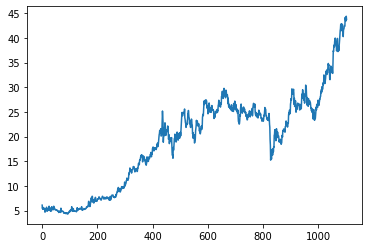

In [7]:
plt.plot(np.asarray(df.carbon_price))
plt.show()

# Data preprocessing

## Handle missing values

In [8]:
df = df.fillna(method='bfill')

In [9]:
df.head()

,carbon_price,oil_price,gas_price,stock_market_index_level,energy_price,coal_price,news_signal
Date,,,,,,,
2017-01-02,6.12,56.82,49.45,363.18,1032.24,82.50,-0.012647
2017-01-03,5.43,55.47,49.45,365.71,1032.24,82.50,-0.012647
2017-01-04,5.72,56.46,50.68,365.26,1032.24,84.20,-0.012647
2017-01-05,5.29,56.89,50.69,365.64,1032.24,85.75,-0.012647
2017-01-06,5.50,57.10,49.77,365.45,1032.24,84.75,-0.012647


## Stationarity checks

In [10]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: carbon_price is 1-order integrated (log difference)!
Variable: oil_price is 1-order integrated (log difference)!
Variable: gas_price is 1-order integrated (log difference)!
Variable: stock_market_index_level is 1-order integrated (log difference)!
Variable: energy_price is 1-order integrated (log difference)!
Variable: coal_price is 1-order integrated (log difference)!
Variable: news_signal is 0-order integrated (log difference)!


In [11]:
df_stationer

,carbon_price,oil_price,gas_price,stock_market_index_level,energy_price,coal_price,news_signal
Date,,,,,,,
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,-0.012647
2017-01-03,-0.119623,-0.024046,0.000000,0.006942,0.000000,0.000000,-0.012647
2017-01-04,0.052030,0.017690,0.024569,-0.001231,0.000000,0.020397,-0.012647
2017-01-05,-0.078151,0.007587,0.000197,0.001040,0.000000,0.018241,-0.012647
2017-01-06,0.038930,0.003685,-0.018316,-0.000520,0.000000,-0.011730,-0.012647
...,...,...,...,...,...,...,...
2021-04-07,-0.008646,0.006672,-0.020841,-0.002162,-0.017229,-0.021568,-0.012647
2021-04-08,-0.008722,0.000633,-0.015973,0.005831,0.015196,-0.023530,-0.012647
2021-04-09,0.004141,-0.003964,-0.007229,0.000847,-0.001271,0.005195,-0.012647


In [12]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

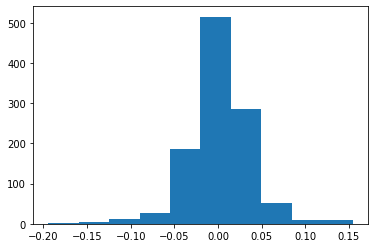

In [13]:
plt.hist(df_stationer.carbon_price)
plt.show()

# Modelling

In [14]:
# Create train-test sets
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)
print(df_test.shape)

# Be careful with time leakage!

(883, 7)
(220, 7)


## ARMA(p,q)

In [16]:
# Fit the model
res = sm.tsa.arma_order_select_ic(df_train['carbon_price'], ic=["aic", "bic","hqic"], trend="nc")

In [17]:
print(res)

{'aic':              0            1            2
0          NaN -3317.213661 -3315.622450
1 -3315.385683 -3315.736433 -3313.760794
2 -3315.265625 -3312.732084 -3313.528397
3 -3313.631264 -3311.728070 -3312.044523
4 -3311.700290 -3310.587710 -3310.069652, 'bic':              0            1            2
0          NaN -3307.647011 -3301.272474
1 -3305.819032 -3301.386457 -3294.627493
2 -3300.915650 -3293.598783 -3289.611771
3 -3294.497963 -3287.811444 -3283.344572
4 -3287.783664 -3281.887759 -3276.586376, 'hqic':              0            1            2
0          NaN -3313.555792 -3310.135645
1 -3311.727813 -3310.249628 -3306.445055
2 -3309.778821 -3305.416344 -3304.383723
3 -3306.315525 -3302.583396 -3301.070914
4 -3302.555616 -3299.614101 -3297.267109, 'aic_min_order': (0, 1), 'bic_min_order': (0, 1), 'hqic_min_order': (0, 1)}


In [18]:
# Parameters
order = (0,1)

# Initialise model
arma_model = ARMA(df_train['carbon_price'],order)

In [19]:
# Fit the model with the selected order
arma_model_fitted = arma_model.fit()
arma_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           carbon_price   No. Observations:                  883
Model:                     ARMA(0, 1)   Log Likelihood                1661.668
Method:                       css-mle   S.D. of innovations              0.037
Date:                Wed, 08 Sep 2021   AIC                          -3317.337
Time:                        22:13:08   BIC                          -3302.987
Sample:                             0   HQIC                         -3311.850
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0015      0.001      1.461      0.144      -0.001       0.003
ma.L1.carbon_price    -0.1837      0.034     -5.375      0.000      -0.251      -0.117
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            5.4424           +0.0000j            5.4424            0.0000
-----------------------------------------------------------------------------
"""

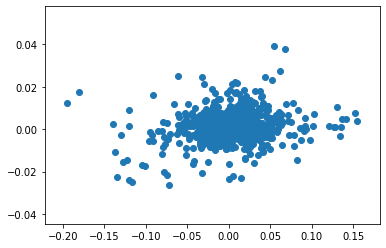

In [20]:
# Compare prediction and actual
arma_y_pred = arma_model.predict(params = arma_model_fitted.params)
y_true = df_train['carbon_price']

plt.scatter(y_true,arma_y_pred)
plt.show()

In [21]:
arma_model_fitted.params[1]

-0.18374364982015648

In [22]:
df_test['carbon_price'].values[1]

-0.02269848651524193

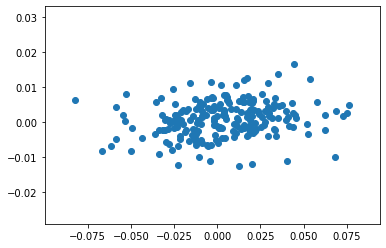

In [23]:
# Compare prediction and actual
arma_y_pred_test = []
for i in range(0,len(df_test)):
    if i == 0:
        pred = arma_model_fitted.params[1]*df_train['carbon_price'].values[-1] + arma_model_fitted.params[0]
    else:
        pred = arma_model_fitted.params[1]*df_test['carbon_price'].values[i-1] + arma_model_fitted.params[0]
        
    arma_y_pred_test.append(pred)

#arma_y_pred_test = arma_model_fitted.forecast(steps=len(df_test))
y_test = df_test['carbon_price']

plt.scatter(y_test,arma_y_pred_test)
plt.show()

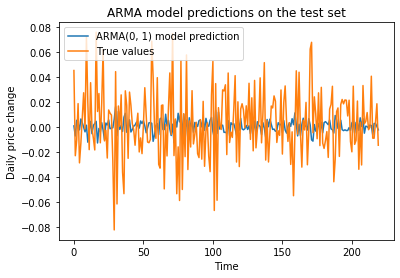

In [24]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(arma_y_pred_test),label=f'ARMA{order} model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('ARMA model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_arma.pdf')
plt.show()

In [25]:
mean_squared_error(arma_y_pred_test,y_test)

0.0007402748649233892

## Random forest

In [26]:
rf_model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=0)

In [27]:
X_train = df_train.shift(1).iloc[1:,:].values

y_train = df_train['carbon_price'].iloc[1:]

X_test = df_test.shift(1).iloc[1:,:].values

y_test = df_test['carbon_price'].iloc[1:]

In [28]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [29]:
# Predict with the model
rf_y_pred = rf_model.predict(X_test)

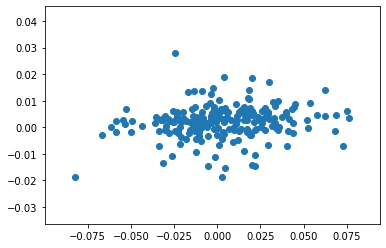

In [30]:
# Compare prediction and actual in the test set
plt.scatter(y_test,rf_y_pred)
plt.show()

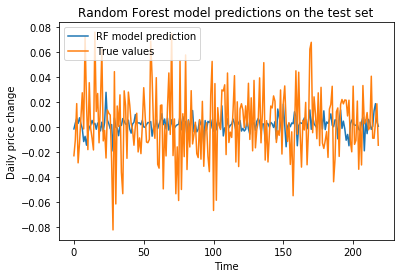

In [31]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(rf_y_pred),label='RF model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('Random Forest model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_rf.pdf')
plt.show()

In [32]:
mean_squared_error(rf_y_pred,y_test)

0.0007469867890945673

## Granger causility

In [33]:
 gc_res = grangercausalitytests(df_stationer[[ 'carbon_price', 'oil_price']], 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2795  , p=0.5971  , df_denom=1099, df_num=1
ssr based chi2 test:   chi2=0.2803  , p=0.5965  , df=1
likelihood ratio test: chi2=0.2802  , p=0.5966  , df=1
parameter F test:         F=0.2795  , p=0.5971  , df_denom=1099, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5811  , p=0.2062  , df_denom=1096, df_num=2
ssr based chi2 test:   chi2=3.1766  , p=0.2043  , df=2
likelihood ratio test: chi2=3.1721  , p=0.2047  , df=2
parameter F test:         F=1.5811  , p=0.2062  , df_denom=1096, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5688  , p=0.0035  , df_denom=1093, df_num=3
ssr based chi2 test:   chi2=13.7942 , p=0.0032  , df=3
likelihood ratio test: chi2=13.7084 , p=0.0033  , df=3
parameter F test:         F=4.5688  , p=0.0035  , df_denom=1093, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9953  , p=0.

In [44]:
# Simple OLS regression
mod = sm.OLS( df_stationer[ 'carbon_price'], df_stationer[ [ 'oil_price', 'gas_price', 'stock_market_index_level',
       'energy_price', 'coal_price', 'news_signal'] ] )

res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           carbon_price   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.128
Method:                 Least Squares   F-statistic:                              28.08
Date:                Wed, 08 Sep 2021   Prob (F-statistic):                    2.53e-31
Time:                        22:18:33   Log-Likelihood:                          2187.9
No. Observations:                1103   AIC:                                     -4364.
Df Residuals:                    1097   BIC:                                     -4334.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [35]:
# Regression with lagged values
X = pd.DataFrame( index = df_stationer.index )
lag = 3
for col in df_stationer.columns:
    variable_name = col + f'_lag{lag}'
    X[ variable_name ] = df_stationer[ col ].shift( lag ) 

X = sm.add_constant(X)
print( X.tail() )
y = df_stationer.loc[ :, 'carbon_price' ]


model = sm.OLS( y, X, missing='drop' )
result = model.fit()
print( result.summary() )

            const  carbon_price_lag3  oil_price_lag3  gas_price_lag3  \
Date                                                                   
2021-04-07    1.0          -0.001886        0.020561        0.008723   
2021-04-08    1.0           0.000000       -0.042680        0.036602   
2021-04-09    1.0           0.040926        0.009448        0.000000   
2021-04-12    1.0          -0.008646        0.006672       -0.020841   
2021-04-13    1.0          -0.008722        0.000633       -0.015973   

            stock_market_index_level_lag3  energy_price_lag3  coal_price_lag3  \
Date                                                                            
2021-04-07                       0.006080           0.006458         0.002139   
2021-04-08                       0.007009          -0.010791         0.000000   
2021-04-09                       0.000000           0.000000         0.001423   
2021-04-12                      -0.002162          -0.017229        -0.021568   
2021-04-1

In [36]:
# Define forward selected regression model
def forward_selected( df, response, lags ):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data
    
    lags: integer, number of lags used

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    data = df
    for lag in range( 1, lags + 1 ):
        lag_data = df.shift( lag )
        lag_data.columns = [ str( col ) + f'_lag{ lag }' for col in lag_data.columns ]
        data = pd.concat( [ data, lag_data ], axis = 1 )
    
    # Add constant
    # data = sm.add_constant( data )
    remaining = set( data.columns )

    remaining.difference_update(df.columns)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(sorted(selected + [candidate])))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(sorted(selected)))
    model = smf.ols(formula, data).fit()
    return model

In [37]:
lags = 5
response = 'carbon_price'
model = forward_selected( df_stationer, response, lags )

print( model.model.formula )

print( model.summary() )

print( model.params )

carbon_price ~ carbon_price_lag1 + carbon_price_lag2 + carbon_price_lag5 + coal_price_lag1 + coal_price_lag2 + coal_price_lag4 + energy_price_lag3 + gas_price_lag3 + news_signal_lag1 + news_signal_lag3 + news_signal_lag4 + oil_price_lag3 + stock_market_index_level_lag2 + stock_market_index_level_lag3 + stock_market_index_level_lag4 + 1
                            OLS Regression Results                            
Dep. Variable:           carbon_price   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     6.282
Date:                Wed, 08 Sep 2021   Prob (F-statistic):           6.78e-13
Time:                        22:16:34   Log-Likelihood:                 2154.9
No. Observations:                1098   AIC:                            -4278.
Df Residuals:                    1082   BIC:                            -4198.
Df Model:                     

In [38]:
# Rolling OLS
def RollingOLS( data, y, X, window ):
    results = {}
    pvalues = pd.DataFrame( columns = X.columns, index = data.index[ window:data.shape[ 0 ] ] )
    coefs = pd.DataFrame( columns = X.columns, index = data.index[ window:data.shape[ 0 ] ] )

    for end_date in range( window, data.shape[ 0 ] ):
        start_date = end_date - window + 1
        model = sm.OLS( y.iloc[ start_date:end_date ], X.iloc[ start_date:end_date, : ], missing='drop' )
        result = model.fit()
        # print( result.summary() )
        results[ data.index[ end_date ] ] = result  
        pvalues.iloc[ start_date - 1, : ] = result.pvalues
        coefs.iloc[ start_date - 1, : ] = result.params

    return results, pvalues, coefs



In [39]:
results, pvalues, coefs = RollingOLS( df_stationer, y, X, 200 )
print( pvalues )

               const carbon_price_lag3 oil_price_lag3 gas_price_lag3  \
Date                                                                   
2017-10-11  0.449714          0.938458       0.560385       0.614553   
2017-10-12  0.442355          0.933627       0.566153       0.616115   
2017-10-13  0.440644          0.933362       0.565181       0.615111   
2017-10-16  0.484405          0.852924       0.521736       0.608142   
2017-10-17  0.460533          0.824124       0.483588       0.635524   
...              ...               ...            ...            ...   
2021-04-07  0.731005          0.790535       0.937125       0.621337   
2021-04-08  0.680418          0.565794       0.705942       0.784427   
2021-04-09  0.666022          0.571717        0.67866       0.801053   
2021-04-12  0.646987          0.609686       0.683372       0.769602   
2021-04-13   0.65754          0.592111       0.683664       0.762658   

           stock_market_index_level_lag3 energy_price_lag3 coal

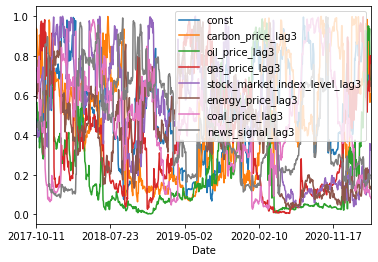

In [40]:
# Plot p values
pvalues.plot.line()

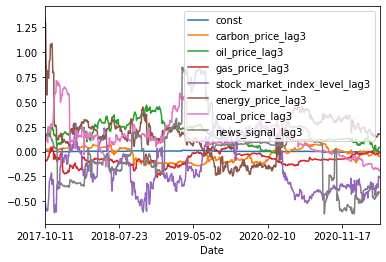

In [41]:
# Plot p values
coefs.plot.line()